# Fiji Energy Workshop 2024: Accessing CMIP6 data.
## CMIP6 data can be accessed in several ways. Here, we will download the same data using different approaches:
* Access using Google Cloud
* Access using ESGF Website
* Access using ESGF-API
* Access using Intake-ESM
     

### The Pros and Cons for each method is listed.

| Method                | Pros                                                | Cons                                                    |
|-----------------------|------------------------------------------------------|--------------------------------------------------------|
| **Google Cloud**      | - High download speeds.                             | - May incur additional costs for storage and network.  |
|                       | - Scalable for large data processing.               | - Requires a Google account.                            |
|                       | - Integrates with other Google Cloud tools.         | - Familiarity with Google Cloud required.              |
| **ESGF Website**      | - User-friendly interface for browsing datasets.    | - Slower download speeds compared to cloud services.   |
|                       | - Direct download to local systems.                  | - Limited automation for large-scale downloads.        |
| **ESGF-API**          | - Supports automated data access.                    | - Requires API knowledge and programming skills.       |
|                       | - Custom search queries for refined results.         | - Dependency issues may arise.                          |
| **Intake-ESM**        | - Seamless Python integration for data analysis.    | - Requires additional setup for proper configuration.  |
|                       | - Easier metadata management and querying.           | - Python dependency can be challenging for non-users.  |


# Access using Google Cloud

### Import all relevant modules

In [ ]:
import pandas as pd
import xarray as xr
import zarr
import fsspec
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### Explore the data catalogue. We read the csv file as a dataframe using the pandas package. 

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

### The columns of the dataframe relate to the [CMIP6 controlled vocabulary](https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q/edit). The complete list of CMIP variables is listed in this [table](https://airtable.com/shrgcENhJZU1y3ye0/tbleXPCaJeYeIzAhR). We will select monthly surface air temperature for historical experiments.

In [ ]:
df_ts = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == 'historical'")
df_ts

### We will select the models from CSIRO-ARCCSS by filtering through the institution_id.

In [ ]:
df_ts_au = df_ts.query('institution_id == "CSIRO-ARCCSS"')
df_ts_au

### We will load the data corresponding to the first row using the corresponding path from the zstore. 

In [ ]:
zstore = df_ts_au.zstore.values[0]
print(zstore)

### We will create a mapping interface to the store and then load the data with xarray and zarr.

In [ ]:
mapper = fsspec.get_mapper(zstore)
dt = xr.open_zarr(mapper, consolidated=True)
dt

### We will plot the first time slot.

In [ ]:
dt.tas.isel(time=0).plot()

### Replot using Robinson Projection

In [ ]:
fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Robinson()))

dt.tas.isel(time=0).plot(
    ax=axis,
    transform=ccrs.PlateCarree(), 
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.5},
    robust=True,
    cmap="magma"
)
axis.coastlines() 
axis.set_title("January 1850")

# Access using ESGF Website

### CMIP6 data can be easily downloaded using the [ESGF Metgrid Search Page](https://aims2.llnl.gov/search). 

### An example of CMIP6 data query is shown below:

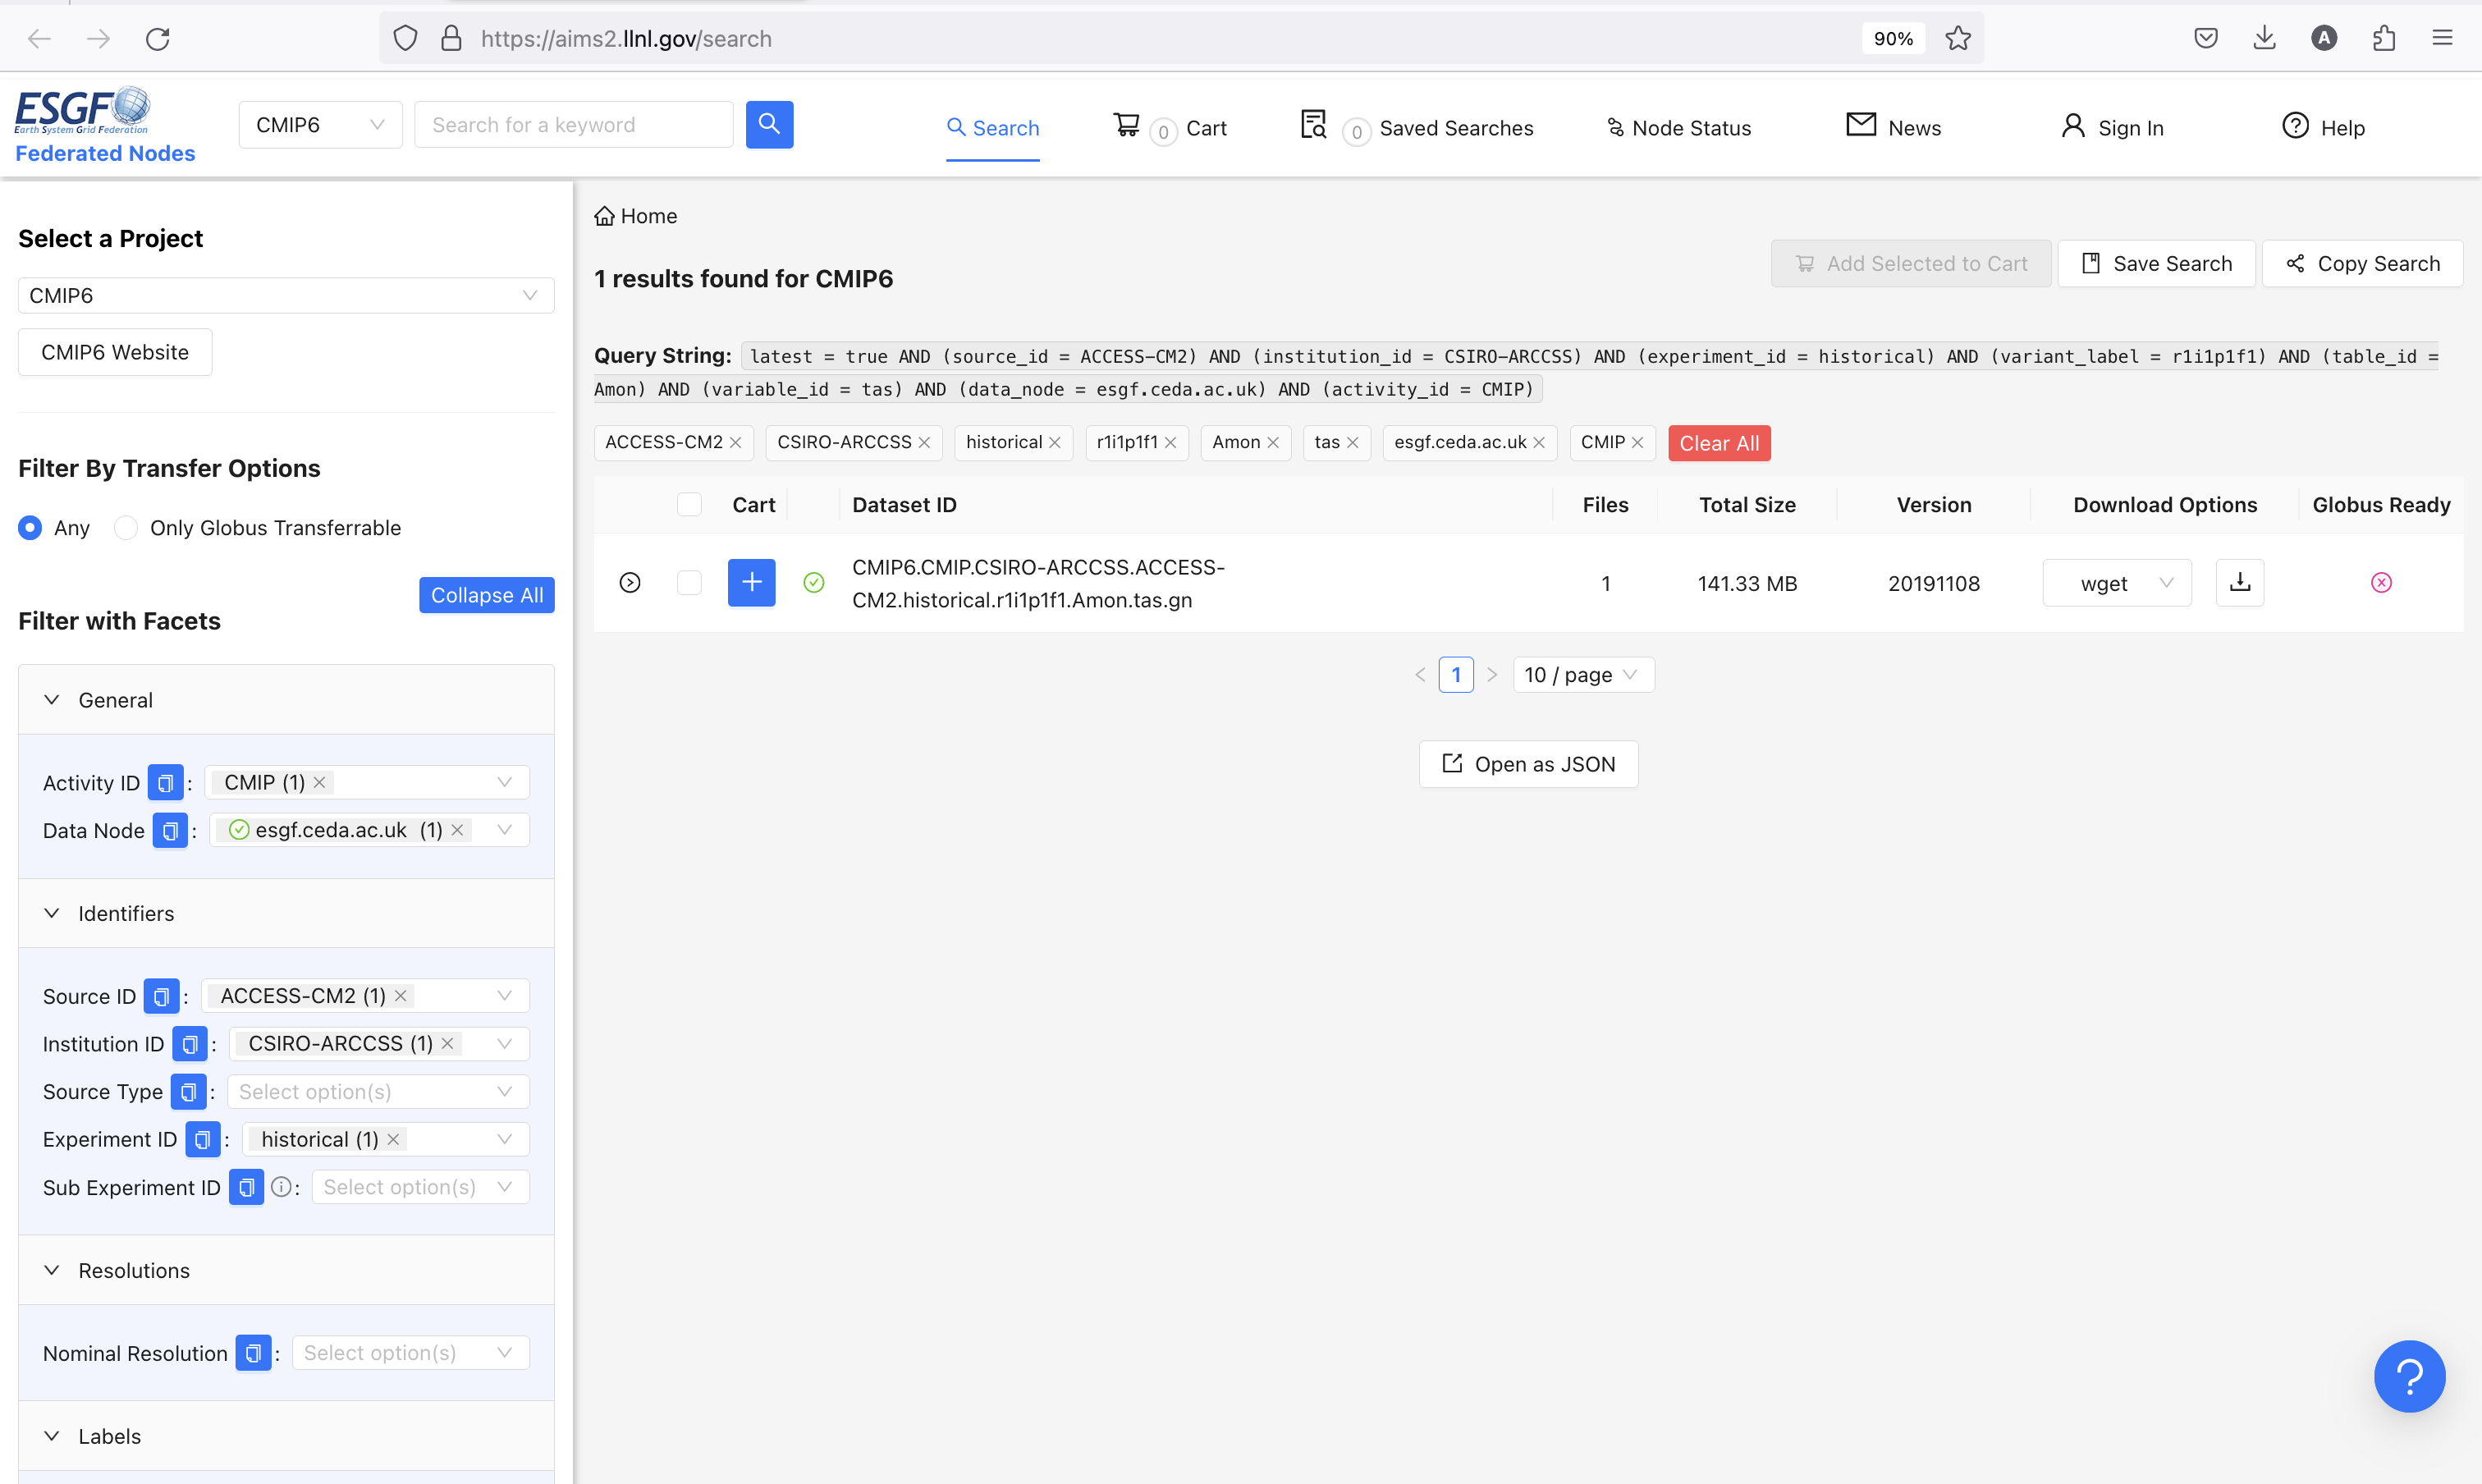

### The CMIP6 query can be downloaded using the wget script available from the "Download Options". Full tutorials are available from the official [website](https://esgf.github.io/esgf-user-support/index.html).

# Access using ESGF-API

### [Earth System Grid Federation](https://esgf.llnl.gov/) infrustructure can also be used to access CMIP6 data using the [ESGF Search API](https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API).

### Import all relevant modules

In [ ]:
from pyesgf.search import SearchConnection

### Several [nodes](https://wcrp-cmip.org/map/) across the globe host CMIP data. We will query data on one node by connecting to their server

In [ ]:
conn = SearchConnection('https://esgf.ceda.ac.uk/esg-search',distrib=False)

### We will search for the same data as above.

In [ ]:
ctx = conn.new_context(
    facets='project,experiment_id',
    project='CMIP6',
    table_id='Amon',
    institution_id="CSIRO-ARCCSS",
    experiment_id='historical',
    source_id='ACCESS-CM2',
    variable='tas',
    variant_label='r1i1p1f1',
)

### We will extract the url for the datasets.

In [ ]:
result = ctx.search()[0]
files = result.file_context().search()
opendap_url=files[0].opendap_url
opendap_url

In [ ]:
de = xr.open_dataset(opendap_url,chunks={'time':480})
de

### We will plot the first time slot.

In [ ]:
de.tas.isel(time=0).plot()

### Replot using Robinson Projection

In [ ]:
fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Robinson()))

de.tas.isel(time=0).plot(
    ax=axis,
    transform=ccrs.PlateCarree(), 
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.5},
    robust=True,
    cmap="magma"
)
axis.coastlines() 
axis.set_title("January 1850")

# Access using Intake-ESM

### Import all relevant modules

In [ ]:
import intake
import warnings
warnings.filterwarnings("ignore")

### [Intake-ESM](https://intake-esm.readthedocs.io/en/latest/) package provides a high-level interface to searching CMIP6 data. We search the [collection spec](https://github.com/NCAR/esm-collection-spec/) using the information stored in the .json file using intake.

In [ ]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

### We will now build the search query to export to a dataframe.

In [ ]:
cat = col.search(
    table_id='Amon',
    institution_id="CSIRO-ARCCSS",
    experiment_id=['historical'],
    source_id='ACCESS-CM2',
    variable_id='tas',
    member_id='r1i1p1f1',
    grid_label='gn')
cat.df

### Intake-ESM automatically opens the dataset.

In [ ]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True})
list(dset_dict.keys())

### Get data using Xarrays

In [ ]:
ds = dset_dict['CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.Amon.gn']
ds

### We will plot the first time slot.

In [ ]:
ds.tas.isel(time=0).plot()

### Replot using Robinson Projection

In [ ]:
fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Robinson()))

ds.tas.isel(time=0).plot(
    ax=axis,
    transform=ccrs.PlateCarree(), 
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.5},
    robust=True,
    cmap="magma"
)
axis.coastlines() 
axis.set_title("January 1850")